## HH Model

### Libraries


In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Standard Params

In [2]:
#*****************************************
#STANDARD PARAMS
#*******************************************


#-----------------------
# sodium current (I_Na)
#-----------------------
g_Na = 24
V_Na = 55
theta_m = -30
sigma_m = 9.5
theta_h = -53
sigma_h = -7
theta_ht = -40.5
sigma_ht = -6
#--------------------------------------------
# delayed rectifier potassium current (I_Kdr)
#--------------------------------------------
g_Kdr = 3
V_K = -90
theta_n = -30
sigma_n = 10
theta_nt = -27
sigma_nt = -15
#---------------------
# leaky current (I_L)
#---------------------
g_L = 0.05
V_L = -70
#--------------------------------
# A-type potassium current (I_KA)
#--------------------------------
g_KA = 1.4
theta_a = -50
sigma_a = 20
theta_b = -80
sigma_b = -6
tau_b = 15
#---------------------------------------
# high threshold calcium current (I_Cal)
#---------------------------------------
g_Cal = 0.0045
V_Cal = 150 #
V12cal = -12
K_Cal = 7
alpha_cal = 0.6
beta_cal = -0.02
#-----------------------------------------------------
# calcium activated nonspecific cation current (I_CAN)
#-----------------------------------------------------
g_CAN = 0.025 #0.025
V_CAN = 30
alpha_can = 0.0056
beta_can = 0.0125
#------------------------------------
# calcium concentration dynamics (Ca)
#------------------------------------
F = 96.500
r0 = 4
r1 = 0.25
Ca0 = 0.1
tau_Ca = 100 #100
#---------------------------------------
# afterhyperpolarization current (I_AHP)
#---------------------------------------
g_AHP = 0.2
V_AHP = -90
alpha_ahp = 0.05
beta_ahp = 0.2

### Functions (currents, plots, etc)

In [16]:
def sodium_current(V, h, theta_ht, sigma_ht, theta_h, sigma_h, dt, theta_m, sigma_m, g_Na, V_Na):

  tau_h = 0.37 + 2.78 * (1/(1 + np.exp(-(V-theta_ht)/sigma_ht)))
  h_inf = 1/(1 + np.exp(-(V-theta_h)/sigma_h))
  dhdt = (h_inf - h)/tau_h
  h = h + dhdt*dt

  m_inf = 1/(1 + np.exp(-(V-theta_m)/sigma_m))

  I_Na = g_Na * m_inf**3 * h * (V - V_Na)

  return I_Na, h

def potassium_Kdr(V, n, theta_nt, sigma_nt, theta_n, sigma_n, dt, g_Kdr, V_K):

  tau_n = 0.37 + 1.85 * (1/(1 + np.exp(-(V-theta_nt)/sigma_nt)))
  n_inf = (1/(1 + np.exp(-(V-theta_n)/sigma_n)))
  dndt = (n_inf - n)/tau_n
  n = n + dndt*dt

  I_Kdr = g_Kdr * n**4 * (V - V_K)

  return I_Kdr, n

def potassium_KA(V, V_K, g_KA, b, dt):

  a_inf = 1/(1 + np.exp(-(V-theta_a)/sigma_a))
  b_inf = 1/(1 + np.exp(-(V-theta_b)/sigma_b))
  dbdt = (b_inf - b)/tau_b
  b = b + dt*dbdt

  I_KA = g_KA * a_inf**3 * b * (V - V_K)

  return I_KA, b

def CaL_current(V, V_Cal, V12cal, K_Cal, alpha_cal, beta_cal, dt, x_cal):

  tau_Cal = 10**(alpha_cal + beta_cal*V)
  x_inf_cal = 1/(1+np.exp(-(V- V12cal)/K_Cal))
  dx_caldt = (x_inf_cal - x_cal)/tau_Cal
  x_cal = x_cal + dt*dx_caldt

  I_CaL = g_Cal * x_cal**2 * (V - V_Cal)

  return I_CaL, x_cal

def CAN_current(V, V_CAN, Ca, alpha_can, beta_can, x_can, dt, g_CAN):

  x_inf_can = (alpha_can * Ca)/((alpha_can * Ca) + beta_can)
  tau_can = 1/((alpha_can * Ca) + beta_can)
  dx_candt = (x_inf_can - x_can)/tau_can
  x_can = x_can + dt*dx_candt

  I_CAN = g_CAN * x_can * (V - V_CAN)

  return I_CAN, x_can

def AHP_current(V, V_AHP, x_ahp, alpha_ahp, beta_ahp, Ca, dt):

  x_inf_ahp = (alpha_ahp * Ca)/((alpha_ahp * Ca)+beta_ahp)
  tau_ahp = 1/((alpha_ahp * Ca)+beta_ahp)
  dx_ahpdt = (x_inf_ahp - x_ahp)/tau_ahp
  x_ahp = x_ahp + dx_ahpdt

  I_AHP = g_AHP * x_ahp**2 * (V - V_AHP)

  return I_AHP, x_ahp

def calcium_dynamics(Ca, F, r1, r0, I_CaL, Ca0, tau_Ca, dt):

  dCadt = ((-1/(2*F))*(r1**(-1))*(1 - r1/r0 + (r1**2)/(3*(r0)**2))**(-1))*I_CaL + (Ca0 - Ca)/(tau_Ca)
  Ca = Ca + dt*dCadt

  return Ca

def event_current(amp_event, t):
  I_inj = 0
  if((t > 2000) & (t <22000)):
    I_inj = amp_event

  return I_inj

def osc_current(amp_osc,t):
  I_osc = 0
  if ((t > 22000) & (t <122000)):
      I_osc = amp_osc*np.sin(2*np.pi*8*t*dt*dt*0.1)
  elif((t>=122000) & (t<124000)):
      I_osc = (1-(t-122000)*0.1*0.5*0.005)*amp_osc*np.sin(2*np.pi*8*t*dt*dt*0.1)
  elif(t >= 122400):
      I_osc = 0.5*amp_osc*np.sin(2*np.pi*8*t*dt*dt*0.1)
  return I_osc

def initial_conditions(theta_h, sigma_h, theta_b, sigma_b, V12cal, K_Cal, Ca0, alpha_can, beta_can, alpha_ahp, beta_ahp):

  global V
  global h
  global n
  global b
  global x_cal
  global Ca
  global I_CaL
  global x_can
  global x_ahp
  global amp_event
  global amp_osc


  V = -70
  h = 1/(1 + np.exp(-(V-theta_h)/sigma_h))
  n= (1/(1 + np.exp(-(V-theta_n)/sigma_n)))
  b = 1/(1 + np.exp(-(V-theta_b)/sigma_b))
  x_cal = 1/(1+np.exp(-(V- V12cal)/K_Cal))

  Ca = Ca0
  I_CaL = 0
  x_can = (alpha_can * Ca)/((alpha_can * Ca) + beta_can)
  x_ahp = (alpha_ahp * Ca)/((alpha_ahp * Ca)+beta_ahp)

  #event and osc amps
  amp_event = 0.65
  amp_osc   = 0.5

def PLOT_1(monitor_1):

  labels = [
      'V',
      '$x_{cal}$',
      'Ca',
      '$x_{can}$',
      '$I_{inj}$'
  ]

  fig, ax = plt.subplots(len(monitor_1[0]), figsize = (8,6))

  for i in range(len(monitor_1[0])):
    ax[i].plot(np.arange(0,T, 1)/100, np.array(monitor_1).T[i])
    ax[i].set_ylabel(labels[i])
    #ax[i].set_xlim(0,1600)
    if (i < (len(monitor_1[0]) - 1)):
      ax[i].set_xticks([])
    ax[-1].set_xlabel('time (ms)')

  plt.tight_layout()
  fig.subplots_adjust(hspace=0)

def PLOT_currents(monitor_currents):

  labels = ['I_L',
            'I_Na',
            'I_Kdr',
            'I_KA',
            'I_CaL',
            'I_CAN',
            'I_AHP',
            'I_inj',
            'I_osc']


  fig, ax = plt.subplots(len(monitor_currents[0]), figsize = (8,12))

  for i in range(len(monitor_currents[0])):
    ax[i].plot(np.arange(0,T, 1)/100, np.array(monitor_currents).T[i])
    ax[i].set_ylabel(labels[i])
    #ax[i].set_xlim(0,1600)
    if (i < (len(monitor_currents[0]) - 1)):
      ax[i].set_xticks([])

  plt.tight_layout()
  fig.subplots_adjust(hspace=0)


### Simulation 001

Testing the setup

In [14]:

initial_conditions(theta_h, sigma_h, theta_b, sigma_b, V12cal, K_Cal, Ca0, alpha_can, beta_can, alpha_ahp, beta_ahp)

amp_osc = 0.55
#euler----
dt = 0.01

g_CAN = 0.03

#monitor
monitor_1 = []
monitor_currents = []


T = 200000
for t in range(T):

  #CURRENTS---
  #------------------------------------------------------------------------------------------------------
  I_Na, h = sodium_current(V, h, theta_ht, sigma_ht, theta_h, sigma_h, dt, theta_m, sigma_m, g_Na, V_Na)
  I_Kdr, n = potassium_Kdr(V, n, theta_nt, sigma_nt, theta_n, sigma_n, dt, g_Kdr, V_K)
  I_KA, b = potassium_KA(V, V_K, g_KA, b, dt)
  I_CaL, x_cal = CaL_current(V, V_Cal, V12cal, K_Cal, alpha_cal, beta_cal, dt, x_cal)
  I_CAN, x_can = CAN_current(V, V_CAN, Ca, alpha_can, beta_can, x_can, dt, g_CAN)
  I_AHP, x_ahp = AHP_current(V, V_AHP, x_ahp, alpha_ahp, beta_ahp, Ca, dt)
  I_L  = g_L  * (V - V_L)
  Ca = calcium_dynamics(Ca, F, r1, r0, I_CaL, Ca0, tau_Ca, dt)
  I_inj = event_current(amp_event,t)
  I_osc = osc_current(amp_osc, t)
  #-------------------------------------------------------------------------------------------------------




  #membrane potential
  V = V + (dt)*(-(I_Kdr+ I_L + I_Na+ I_KA*0 + I_CaL + I_CAN + I_AHP) + I_inj + I_osc)


  #MONITORS
  monitor_1.append([V,
                    x_cal,
                    Ca,
                    x_can,
                    I_inj + I_osc])

  monitor_currents.append([I_L,
                            I_Na,
                            I_Kdr,
                            I_KA,
                            I_CaL,
                            I_CAN,
                            I_AHP,
                            I_inj,
                            I_osc]
                            )

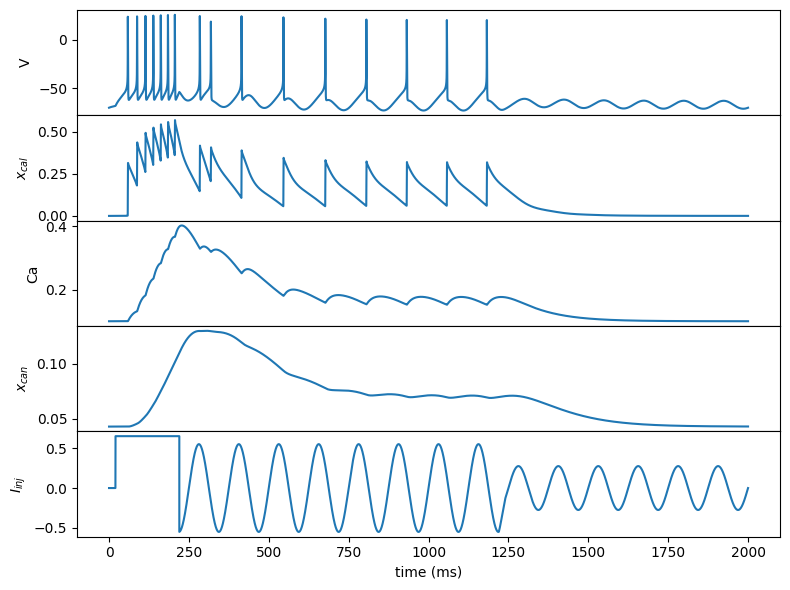

In [17]:
PLOT_1(monitor_1)

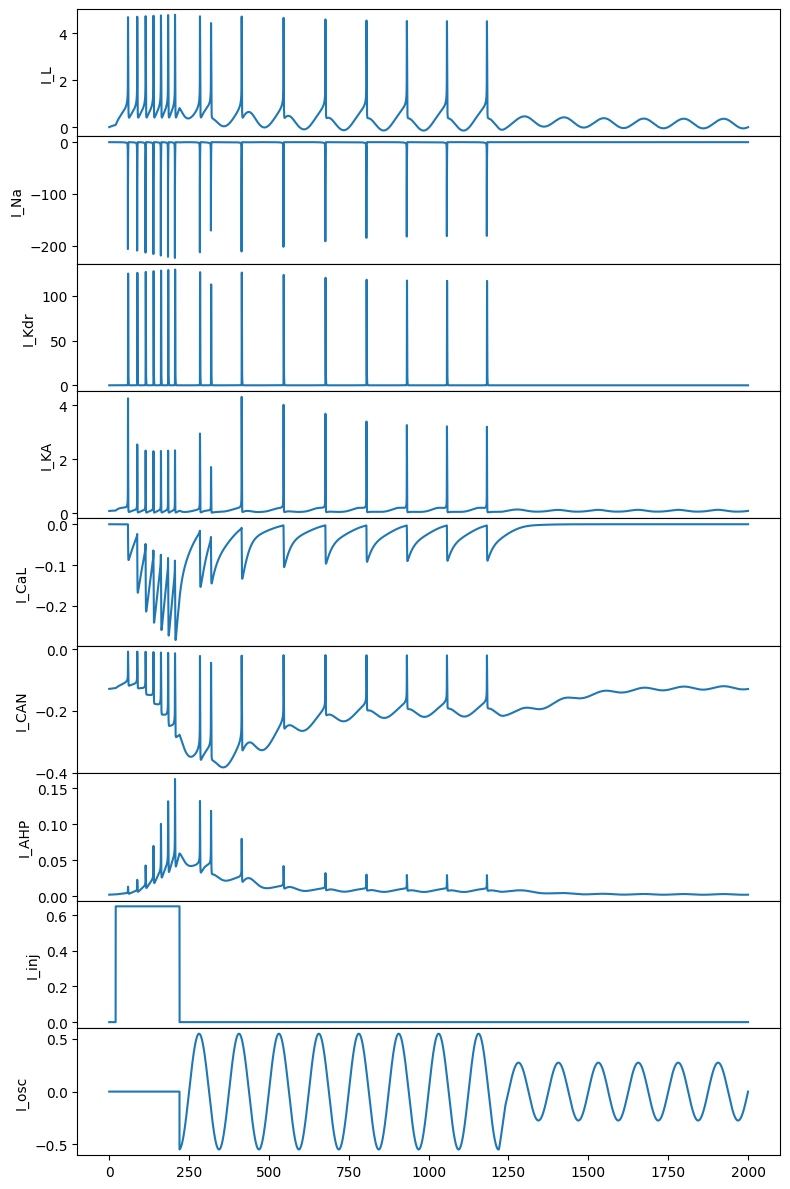

In [13]:
PLOT_currents(monitor_currents)

### Simulation multiple phases

In [ ]:
def osc_current_vary(amp_osc,t,f,phase):
  I_osc = 0
  if ((t > 22000) & (t <122000)):
      I_osc = amp_osc*np.sin(2*np.pi*f*t*dt*dt*0.1 - phase)
  elif(t > 122000):
      I_osc = 0.5*amp_osc*np.sin(2*np.pi*f*t*dt*dt*0.1 - phase)
  return I_osc

VVV = []
for phase in [0.0, 0.3, 0.6, 0.9]:
  initial_conditions(theta_h, sigma_h, theta_b, sigma_b, V12cal, K_Cal, Ca0, alpha_can, beta_can, alpha_ahp, beta_ahp)

  amp_osc = 0.55
  #euler----
  dt = 0.01
  f = 8

  g_CAN = 0.03

  #monitor
  monitor_1 = []
  monitor_currents = []


  T = 280000
  for t in range(T):

    #CURRENTS---
    #------------------------------------------------------------------------------------------------------
    I_Na, h = sodium_current(V, h, theta_ht, sigma_ht, theta_h, sigma_h, dt, theta_m, sigma_m, g_Na, V_Na)
    I_Kdr, n = potassium_Kdr(V, n, theta_nt, sigma_nt, theta_n, sigma_n, dt, g_Kdr, V_K)
    I_KA, b = potassium_KA(V, V_K, g_KA, b, dt)
    I_CaL, x_cal = CaL_current(V, V_Cal, V12cal, K_Cal, alpha_cal, beta_cal, dt, x_cal)
    I_CAN, x_can = CAN_current(V, V_CAN, Ca, alpha_can, beta_can, x_can, dt, g_CAN)
    I_AHP, x_ahp = AHP_current(V, V_AHP, x_ahp, alpha_ahp, beta_ahp, Ca, dt)
    I_L  = g_L  * (V - V_L)
    Ca = calcium_dynamics(Ca, F, r1, r0, I_CaL, Ca0, tau_Ca, dt)
    I_inj = event_current(amp_event,t)
    I_osc = osc_current_vary(amp_osc, t, f, phase)
    #-------------------------------------------------------------------------------------------------------




    #membrane potential
    V = V + (dt)*(-(I_Kdr+ I_L + I_Na+ I_KA*0 + I_CaL + I_CAN + I_AHP) + I_inj + I_osc)

    monitor_1.append(V)
  VVV.append(monitor_1)
    #MONITORS
  '''
    monitor_1.append([V,
                      x_cal,
                      Ca,
                      x_can,
                      I_inj + I_osc])
  VVV.append(monitor_1)


    monitor_currents.append([I_L,
                              I_Na,
                              I_Kdr,
                              I_KA,
                              I_CaL,
                              I_CAN,
                              I_AHP,
                              I_inj,
                              I_osc]
                              )

'''

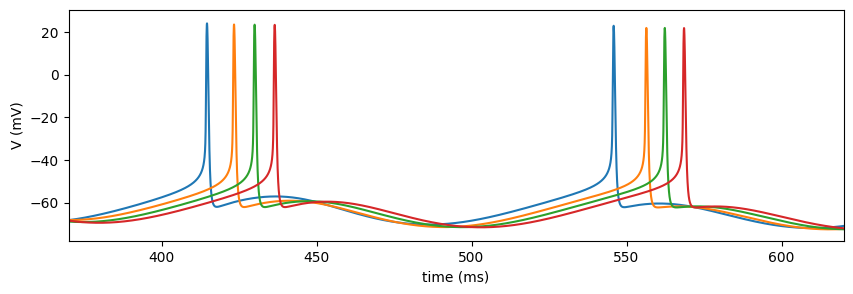

In [ ]:
plt.figure(figsize= (10,3))
for i in VVV:
  plt.plot(np.arange(0,T,1)/100,i)
plt.xlim(370,620)
plt.xlabel('time (ms)')
plt.ylabel("V (mV)")
plt.show()


# LIF MODEL

In [ ]:
def osc_current(amp_osc,t):
  I_osc = 0
  if ((t > 22000) & (t <122000)):
      I_osc = amp_osc*np.sin(2*np.pi*8*t*dt*dt*0.1)
  elif((t>=122000) & (t<124000)):
      I_osc = (1-(t-122000)*0.1*0.5*0.005)*amp_osc*np.sin(2*np.pi*8*t*dt*dt*0.1)
  elif(t >= 122400):
      I_osc = 0.5*amp_osc*np.sin(2*np.pi*8*t*dt*dt*0.1)
  return I_osc

In [ ]:
def osc_current_vary(amp_osc,t,f,phase):
  I_osc = 0
  if ((t > 22000) & (t <122000)):
      I_osc = amp_osc*np.sin(2*np.pi*f*t*dt*dt*0.1 - phase)
  elif(t > 122000):
      I_osc = 0.5*amp_osc*np.sin(2*np.pi*f*t*dt*dt*0.1 - phase)
  return I_osc

In [ ]:
 dt = 0.01
 A_osc = 8.5
 amp_event = 10.5
 V_rest = -60
 reftime = 400
 V_limiar = -50
 A_adp = 6

 tau_adp = 10000
 t0=-500000

 V = V_rest
 tau = 10

 VV = []
 adpp= []
 iinj = []
 T = 200000
 for t in range(T):

  I_osc = osc_current(A_osc, t)
  I_inj = event_current(amp_event,t)

  iinj.append(I_osc + I_inj)
  I_adp = (A_adp/tau_adp)*(t-t0)*np.exp(-((t-t0)/tau_adp)+1)

  adpp.append(I_adp)

  V = V + dt/tau*(V_rest - V  + I_osc + I_inj + I_adp)






  reftime+=1




  if ( (V > V_limiar) & (reftime >300)):
    V = 20;
    disparo = 1;
    reftime = 0;

  elif((V > V_limiar) & (reftime ==1)):
    V = -70


  else:
    disparo = 0;

  if(disparo == 1):
    t0 = t

  VV.append(V)


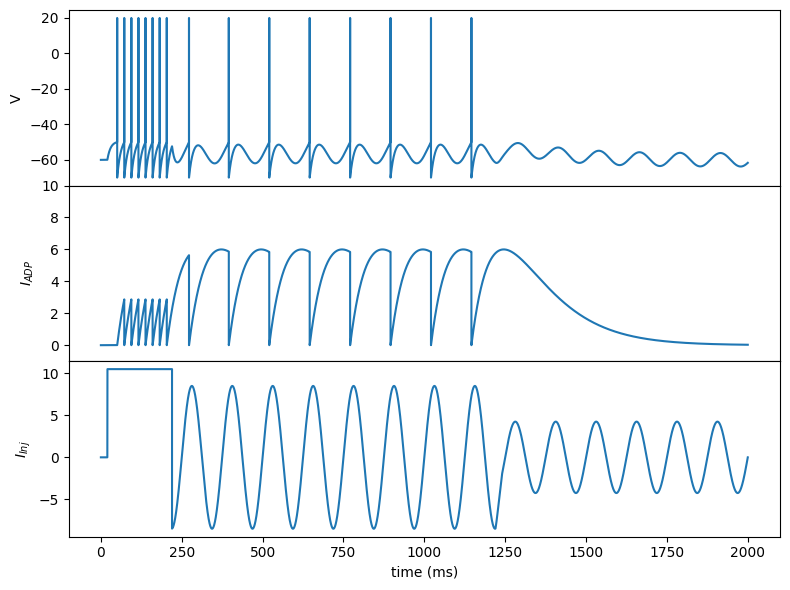

In [ ]:
labels = [
    'V',
    '$I_{ADP}$',
    '$I_{Inj}$',

]

fig, ax = plt.subplots(3, figsize = (8,6))

ax[0].plot(np.arange(0,T, 1)/100,VV)
ax[1].plot(np.arange(0,T, 1)/100,adpp)
ax[2].plot(np.arange(0,T, 1)/100,iinj)

for i in range(3):
  ax[i].set_ylabel(labels[i])
if (i < 2):
    ax[i].set_xticks([])
ax[-1].set_xlabel('time (ms)')


ax[1].set_ylim(-1,10)



plt.tight_layout()
fig.subplots_adjust(hspace=0)

In [ ]:
VV = []
for fase in [0.0, 0.3, 0.6, 0.9]:
  VV.append([])

  dt = 0.01
  A_osc = 5.5
  amp_event = 10.5
  V_rest = -60
  reftime = 400
  V_limiar = -50
  A_adp = 6

  tau_adp = 10000
  t0=-500000

  V = V_rest
  tau = 10


  adpp= []
  iinj = []
  T = 180000
  for t in range(T):

    I_osc = osc_current_vary(A_osc, t,8,fase)
    I_inj = event_current(amp_event,t)

    iinj.append(I_osc + I_inj)
    I_adp = (A_adp/tau_adp)*(t-t0)*np.exp(-((t-t0)/tau_adp)+1)

    adpp.append(I_adp)

    V = V + dt/tau*(V_rest - V  + I_osc + I_inj + I_adp)






    reftime+=1




    if ( (V > V_limiar) & (reftime >300)):
      V = 20;
      disparo = 1;
      reftime = 0;

    elif((V > V_limiar) & (reftime ==1)):
      V = -70


    else:
      disparo = 0;

    if(disparo == 1):
      t0 = t

    VV[-1].append(V)

(350.0, 600.0)

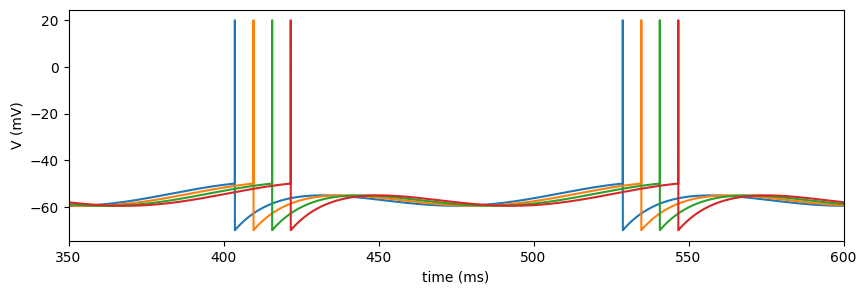

In [ ]:
plt.figure(figsize= (10,3))
for v in VV:
  plt.plot(np.arange(0,T, 1)/100,v)
plt.xlabel('time (ms)')
plt.ylabel("V (mV)")

plt.xlim(350,600)